# Project I: Multi-Armed Bandits

The multi-armed bandit problem considers a resource allocation problem in partially unknown environments. In more detail, the problem refers to the task of allocating a fixed and limited set of resources among alternative choices in a way that maximizes the expected gain. Importantly, each choice's properties are only partially known at the time of allocation and may become better understood with time and/or by allocating resources to a choice. The multi-armed bandit problem is a classic reinforcement learning problem that demonstrates the exploration-exploitation tradeoff dilemma and related concepts in a clear non-associative form. As such, it helps set the foundations of reinforcement learning theory. The multi-armed bandit problem has also applications in various domains such as clinical trials and networking. In this notebook we will experiment with a number of multiarmed bandit algorithms by altering the abstract bandit algorithm.

![robot](img/robot.png)

## Section 1: General Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Section 2: The General Bandit Algorithm

![algorithm](img/abstract_algorithm.png)

Here we declare a general bandit algorithm that accepts various initialization, action selection and update strategies.

In [4]:
def bandit(inputs):
    """
        An abstract k-arm bandit algorithm.

        Args:
            inputs: A dictionary containing the number of actions "k", the number of iterations "horizon",
                    the true unknown rewards "q_star", the initialization strategy function "initialization",
                    the action selection strategy function "action_selection", the update rule function "update rule"
                    and any other parameters required.

        Returns:
            q_estimates: list - the estimates of the q values.
            total_reward: float - the cummulative reward
            mean_rewards: list - the consecutive mean rewards
            regret: list - the true maximum regret

    """
    
    #Initializing rewards and regret (used mainly for evaluation purposes)
    total_reward = 0
    mean_rewards = np.zeros(inputs["horizon"])
    regret = np.zeros(inputs["horizon"])
    
    #Initialize an action selection counter (used mainly for the true average update rule)
    action_select_counter = np.zeros(k)
    
    ### INITIALIZE THE ESTIMATES
    q_estimates = inputs["initialization"](inputs["k"], inputs["q_star"])
    
    for t in range(1,inputs["horizon"]+1): # loop over the horizon
        
        ### ACTION SELECTION
        action = inputs["action_selection"](q_estimates, inputs, t, action_select_counter)    
        # Update action counter
        action_select_counter[action] += 1
    
        ## BANDIT CALL
        reward = run_bandit(action, q_star) 
        
        #Calculate reward, mean reward and regret for evaluatuion purposes
        total_reward += reward      
        mean_rewards[t-1] = total_reward/t
        regret[t-1] = np.max(q_star) - reward # We use the true maximum to calculate the regret :)
        
        ## UPDATE ACTION-VALUE ESTIMATES
        q_estimates = inputs["update_rule"](q_estimates, action, reward, inputs, action_select_counter, mean_rewards[t-1])
        
    return q_estimates, total_reward, mean_rewards, regret

In [5]:
def run_bandit(action, q_star):
    """ 
        Returns the reward of an action assuming that it follows a normal distribution with variance 1.
        The mean values are extracted from q_star 
    """
    return rng2.normal(q_star[action], 1)

### 2.1. Initialization strategies
Using the q* values, we create initialization methods that implement zero, pessimistic, average, optimistic and random estimate initializations for the bandit algorithm:

#### Estimate initialization with zeroes:

In [6]:
def ZeroInitialization(k, q_star):
    """Zero initialization"""
    return np.zeros(k)

#### Pessimistic estimate initialization:

In [7]:
def MinInitialization(k, q_star):
    """Min initialization"""
    return np.ones(k) * np.min(q_star)

#### Mean estimate initialization:

In [8]:
def MeanInitialization(k, q_star):
    """Mean initialization"""
    return np.ones(k) * np.mean(q_star)

#### Optimistic estimate initialization:

In [9]:
def MaxInitialization(k, q_star):
    """Max initialization"""
    return np.ones(k) * np.max(q_star)

#### Estimate initialization with random numbers:

In [10]:
def RandomInitialization(k, q_star):
    """Random initialization"""
    return rng3.normal(0, 1, k)  #let's assume we know the distributions and take nice random initial values :)

### 2.2. Action selection strategies

#### Random action selection: 
This strategy selects an action completely at random without taking into account the learned estimates.

In [11]:
def random_action_selection(estimates, bandit_inputs, t, action_select_counter):
    """Choose an action randomly (uniform)"""
    return rng2.randint(inputs["k"])

#### Greedy action selection:
This action selection strategy always selects the best possible action.

In [12]:
def greedy_action_selection(estimates, inputs, t, action_select_counter):
    """ Choose an action using the greedy action selection"""
    return np.argmax(estimates)

#### ε-Greedy action selection:
The implementation of the e-Greedy algorithm for the multi-armed bandit problem.

In [13]:
def e_greedy_action_selection(estimates, inputs, t, action_select_counter):
    """ Choose an action using the e-greedy action selection"""
    # Generate a random number
    p = rng2.rand()
    
    # E-Greedy action selection
    if p < inputs["epsilon"]:
        # Randomly select an action
        return rng2.choice(inputs["k"])
    else:
        # Take greedy action
        return np.argmax(estimates)

#### ε-Greedy with epsion decay action selection:
The implementation of the e-Greedy algorithm with epsilon decay for the multi-armed bandit problem.

In [14]:
def e_decay_greedy_action_selection(estimates, inputs, t, action_select_counter):
    """ Choose an action using the e-greedy with epsilon decay action selection"""
    # Generate a random number
    p = rng2.rand()

    # E-Greedy action selection
    if p < inputs["epsilon"]*np.exp(-inputs["kappa"]*t):
        # Randomly select an action
        action = rng2.choice(inputs["k"])
    else:
        # Take greedy action
        action = np.argmax(estimates)
            
    return action

#### Upper Confidence Bound action selection:
The implementation of the UCB algorithm for the multi armed bandit problem.

In [15]:
def ucb_action_selection(estimates, inputs, t, action_select_counter):
    """ Choose an action using the UCB action selection"""
    t = np.sum(action_select_counter) + 1
    # Select action according to UCB Criteria
    return np.argmax(estimates + inputs["c"] * np.sqrt(np.log(t) / (action_select_counter+1)))

#### SoftMax action selection:
The implementation of the softmax bandit algorithm for the multi-armed bandit problem. 

In [16]:
def softmax_action_selection(estimates, inputs, t, action_select_counter):
    """ Choose an action using the Softmax action selection"""
    # Softmax action selection
    action = rng3.choice(inputs["k"], 1, p=np.exp(estimates/inputs["tau"]) / np.sum(np.exp(estimates/inputs["tau"])))
    return action[0]

### 2.3. Update strategies 

#### True average update rule:

In [17]:
def update_rule(estimates, action, reward, inputs, action_select_counter, mean_reward):
    """ Return the estimates using the true average update rule"""
    # Update the estimates
    estimates[action] = estimates[action] + (reward - estimates[action]) / action_select_counter[action]
    return estimates

#### Constant learning rate update rule:

In [18]:
def update_rule_constant_lr(estimates, action, reward, inputs, action_select_counter, mean_reward):
    # Update the estimates
    """ Return the estimates using the constant learning rate update rule"""
    estimates[action] = estimates[action] + (reward - estimates[action]) / (action_select_counter[action]*inputs["a"])
    return estimates

What about decaying learning rate?

## Section 3: The Case Study Experiment

Here we declare the number of trials and arms of the multi-armed bandit problem. We also select a gaussian probability distribution to generate the true values of each arm and to simulate the randomness of the experiment.

In [19]:
# Number of actions
k = 10
# Number of iterations
horizon = 5000
#Number of trials
trials=100

# Initialization of the true action values (q*) according to a gaussian distribution

q_star = [-0.70318731, -0.49028236, -0.32181433, -1.75507872,  0.20666447, -2.01126457, -0.55725071,  0.33721701,  1.54883597, -1.37073656]
#rng1 = np.random.RandomState(1337) #https://en.wikipedia.org/wiki/Leet
#q_star = rng1.normal(0, 1, k)
#print(q_star)

### 3.1. Experimental procedure 

Define the experimental procedure followed for all experiments

In [20]:
def procedure(inputs, N):
    """ 
        Does "trials" amount of runs of the algorithm specified by the "inputs" dictionary. 
    
        Args:
            inputs: A dictionary containing the number of actions "k", the number of iterations "horizon",
                    the true unknown rewards "q_star", the initialization strategy function "initialization",
                    the action selection strategy function "action_selection", the update rule function "update rule"
                    and any other parameters required.
            trials: The amount of trial runs to execute so we can get the average performance of the algorithm

        Returns:
            average_q_estimates: list - the average estimates of the q values.
            average_total_reward: float - the average cummulative reward
            average_mean_rewards: list - the average consecutive mean rewards
            average_regret: list - the average true maximum regret
    """
    #Initialize the evaluation parameters
    estimates = np.zeros(k)
    total_reward = 0
    mean_rewards = np.zeros(N)
    regret = np.zeros(N)

    #Run the n trials of the experiment
    for i in range(trials):
        i_estimates, i_total_reward, i_mean_rewards, i_regret = bandit(inputs)
        estimates += i_estimates
        total_reward += i_total_reward
        mean_rewards += i_mean_rewards
        regret += i_regret
        
    return estimates/trials, total_reward/trials, mean_rewards/trials, regret/trials #return the average results for all trials

### 3.2. Plotting/printing:
After each experiment we print two plots to evaluate the performance of the algorithm. We print the loss that we incur due to time/rounds spent due to the learning, or else the regret, and the expected reward of the algorithm across the rounds of each experiment.

Definition of the print and plot of the results (we use this throughout the rest of the notebook):

In [21]:
def plot_bandits(N, estimates, total_reward, mean_rewards, regret, q_star):
    """ Plots using matplotlib the regret curve and the average reward curve"""
    print("True q values:{}".format(q_star))
    print("Learned Estimates: {}".format(estimates))
    print("")
    print("Euclidean distance from q_star vector: {}".format(np.linalg.norm(q_star-estimates)))
    print("Total Reward: {}".format(total_reward))
    print("Mean Reward: {}".format(mean_rewards[-1]))

    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,N-1,N), np.cumsum(regret), 'b-')
    ax.set_xlabel("Time")
    ax.set_ylabel("Speed")
    ax.grid()
    ax.set(xlabel='Time Steps', ylabel='Total Regret',
           title='Regret Curve')

    plt.show()

    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,N-1,N), mean_rewards, 'b-')
    ax.set_xlabel("Time")
    ax.set_ylabel("Speed")
    ax.grid()
    ax.set(xlabel='Time Steps', ylabel='Average Reward',
           title='Average Reward Curve')

    plt.show()

Definition of the comp_plot, that plots the comparative plot of the various initializations:

In [22]:
def comp_plot(regret, pes_regret, avg_regret, opt_regret, rnd_regret, \
              mean_rewards, pes_mean_rewards, avg_mean_rewards, opt_mean_rewards, rnd_mean_rewards):
    """ Plots using matplotlib a comparison of the the regret curves and the average reward curves"""
    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,horizon-1,horizon), np.cumsum(regret), 'b-')
    ax.plot(np.linspace(0,horizon-1,horizon), np.cumsum(opt_regret), 'g-')
    ax.plot(np.linspace(0,horizon-1,horizon), np.cumsum(avg_regret), 'r-')
    ax.plot(np.linspace(0,horizon-1,horizon), np.cumsum(pes_regret), 'c-')
    ax.plot(np.linspace(0,horizon-1,horizon), np.cumsum(rnd_regret), 'y-')
    ax.set_xlabel("Time")
    ax.set_ylabel("Speed")
    ax.grid()
    ax.set(xlabel='Time Steps', ylabel='Total Regret',
           title='Regret Curve')
    plt.legend(['Zero','Optimistic','Mean','Pesimistic','Random'])
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,horizon-1,horizon), mean_rewards, 'b-')
    ax.plot(np.linspace(0,horizon-1,horizon), opt_mean_rewards, 'g-')
    ax.plot(np.linspace(0,horizon-1,horizon), avg_mean_rewards, 'r-')
    ax.plot(np.linspace(0,horizon-1,horizon), pes_mean_rewards, 'c-')
    ax.plot(np.linspace(0,horizon-1,horizon), rnd_mean_rewards, 'y-')
    ax.set_xlabel("Time")
    ax.set_ylabel("Speed")
    ax.grid()
    ax.set(xlabel='Time Steps', ylabel='Average Reward',
           title='Average Reward Curve')
    plt.legend(['Zero','Optimistic','Mean','Pesimistic','Random'])
    plt.show()

## Section 11: Exercises

### 11.1. Exercise 1: Implement the gradient bandits action selection and update rule methods yourself:

In [58]:
def gradient_bandits_action_selection(estimates, inputs, t, action_select_counter):
    # Parameters (k and tau)
    k = inputs["k"]
    tau = inputs["tau"]

    # Compute the probabilities for each action (softmax) based on the estimates
    action_probs = np.exp(estimates/tau)/np.sum(np.exp(estimates/tau))

    # Select an action based on the probabilities
    action = rng3.choice(k, p=action_probs)
    return action

def gradient_bandits_update_rule(estimates, action, reward, inputs, action_select_counter, mean_reward):
    # Parameters (k, tau, and alpha)
    k = inputs["k"]
    tau = inputs["tau"]
    alpha = inputs["alpha"]

    # Compute the probabilities for each action (softmax) based on the estimates
    action_probs = np.exp(estimates/tau)/np.sum(np.exp(estimates/tau))

    # Updating the estimate for the current action (A_t)
    estimates[action] = estimates[action] + alpha*(reward - mean_reward)*(1-action_probs[action])

    # Updating the estimate for the other actions
    estimates = np.array([estimates[i] if i == action else estimates[i] - alpha*(reward - mean_reward)*action_probs[i] for i in range(k)])
    return estimates

#### Run the gradient bandits with zeros initialization:

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.32805498 -0.31949162 -0.28717273 -0.45462802 -0.15375647 -0.4673974
 -0.29013782 -0.02730144  2.79831737 -0.4703769 ]

Euclidean distance from q_star vector: 2.636620787857329
Total Reward: 7338.114436874103
Mean Reward: 1.467622887374821


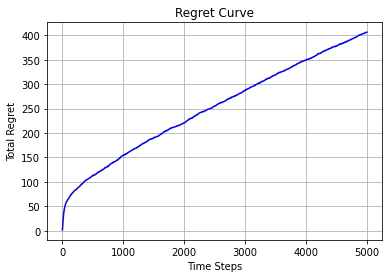

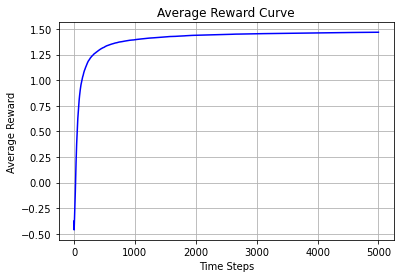

In [35]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "tau"               : 0.3, # The tau parameter
          "alpha"             : 0.1, # The learning rate
          "initialization"    : ZeroInitialization, # Initialization strategy
          "action_selection"  : gradient_bandits_action_selection, # Action selection strategy
          "update_rule"       : gradient_bandits_update_rule # The update rule
         }

#Run the experiment and plot:
estimates_gradient, total_reward_gradient, mean_rewards_gradient, regret_gradient = procedure(inputs,horizon)
plot_bandits(horizon, estimates_gradient, total_reward_gradient, mean_rewards_gradient, regret_gradient, q_star)

#### Will gradient bandits have a different result using other initializations?
Run the gradient bandits using different initializations to find out if you were correct:

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-2.33931955 -2.33075619 -2.2984373  -2.46589259 -2.16502104 -2.47866197
 -2.30140239 -2.03856601  0.7870528  -2.48164147]

Euclidean distance from q_star vector: 5.178875664946735
Total Reward: 7338.114436874103
Mean Reward: 1.467622887374821


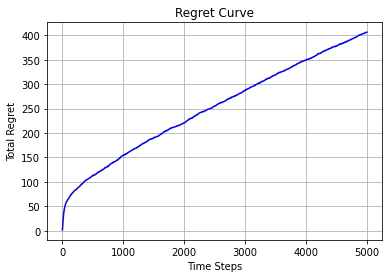

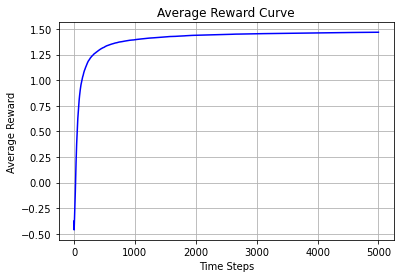

In [36]:
# Pessimistic Initialization
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "tau"               : 0.3, # The tau parameter
          "alpha"             : 0.1, # The learning rate
          "initialization"    : MinInitialization, # Initialization strategy
          "action_selection"  : gradient_bandits_action_selection, # Action selection strategy
          "update_rule"       : gradient_bandits_update_rule # The update rule
         }

#Run the experiment and plot:
min_estimates_gradient, min_total_reward_gradient, min_mean_rewards_gradient, min_regret_gradient = procedure(inputs,horizon)
plot_bandits(horizon, min_estimates_gradient, min_total_reward_gradient, min_mean_rewards_gradient, min_regret_gradient, q_star)

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.83974469 -0.83118133 -0.79886244 -0.96631774 -0.66544618 -0.97908711
 -0.80182753 -0.53899115  2.28662766 -0.98206661]

Euclidean distance from q_star vector: 2.081707370292178
Total Reward: 7338.114436874103
Mean Reward: 1.467622887374821


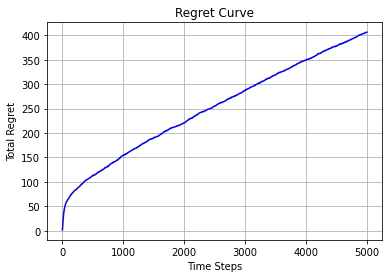

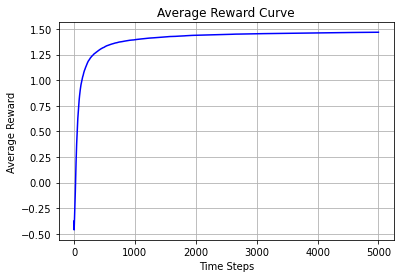

In [37]:
# Average Initialization
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "tau"               : 0.3, # The tau parameter
          "alpha"             : 0.1, # The learning rate
          "initialization"    : MeanInitialization, # Initialization strategy
          "action_selection"  : gradient_bandits_action_selection, # Action selection strategy
          "update_rule"       : gradient_bandits_update_rule # The update rule
         }

#Run the experiment and plot:
avg_estimates_gradient, avg_total_reward_gradient, avg_mean_rewards_gradient, avg_regret_gradient = procedure(inputs,horizon)
plot_bandits(horizon, avg_estimates_gradient, avg_total_reward_gradient, avg_mean_rewards_gradient, avg_regret_gradient, q_star)

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [1.22078099 1.22934435 1.26166324 1.09420795 1.3950795  1.08143857
 1.25869815 1.52153453 4.34715334 1.07845907]

Euclidean distance from q_star vector: 6.8404068881999915
Total Reward: 7338.114436874103
Mean Reward: 1.467622887374821


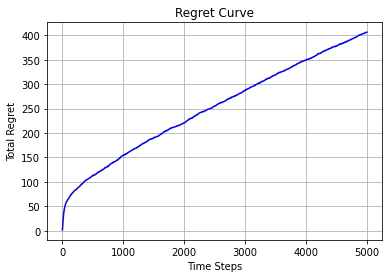

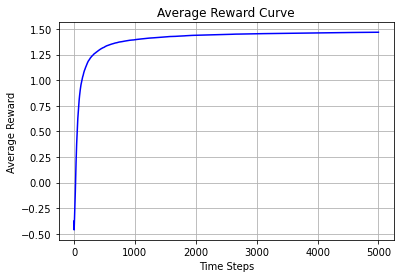

In [38]:
# Optimistic Initialization
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "tau"               : 0.3, # The tau parameter
          "alpha"             : 0.1, # The learning rate
          "initialization"    : MaxInitialization, # Initialization strategy
          "action_selection"  : gradient_bandits_action_selection, # Action selection strategy
          "update_rule"       : gradient_bandits_update_rule # The update rule
         }

#Run the experiment and plot:
max_estimates_gradient, max_total_reward_gradient, max_mean_rewards_gradient, max_regret_gradient = procedure(inputs,horizon)
plot_bandits(horizon, max_estimates_gradient, max_total_reward_gradient, max_mean_rewards_gradient, max_regret_gradient, q_star)

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.31327067 -0.18174159 -0.05089979 -0.40242796  0.22152955 -0.33364746
 -0.245283    0.6304828   1.25126027 -0.39874293]

Euclidean distance from q_star vector: 2.48627490775418
Total Reward: 3702.3505362464043
Mean Reward: 0.740470107249281


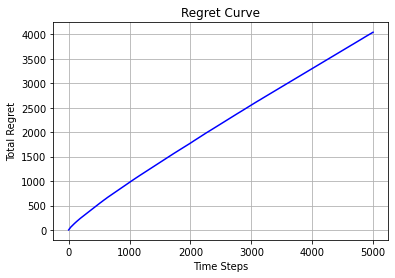

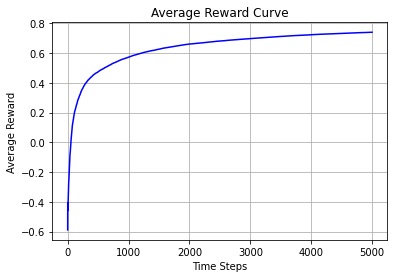

In [39]:
# Random Initialization
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "tau"               : 0.3, # The tau parameter
          "alpha"             : 0.1, # The learning rate
          "initialization"    : RandomInitialization, # Initialization strategy
          "action_selection"  : gradient_bandits_action_selection, # Action selection strategy
          "update_rule"       : gradient_bandits_update_rule # The update rule
         }

#Run the experiment and plot:
rnd_estimates_gradient, rnd_total_reward_gradient, rnd_mean_rewards_gradient, rnd_regret_gradient = procedure(inputs,horizon)
plot_bandits(horizon, rnd_estimates_gradient, rnd_total_reward_gradient, rnd_mean_rewards_gradient, rnd_regret_gradient, q_star)

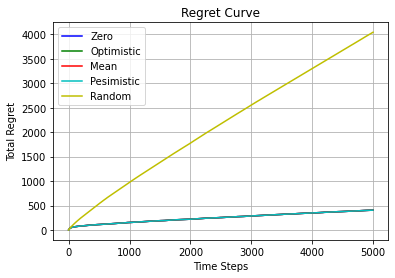

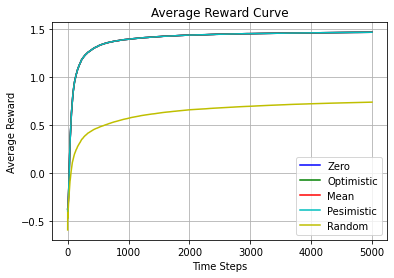

In [40]:
# Compare all
comp_plot(regret_gradient, min_regret_gradient, avg_regret_gradient, max_regret_gradient, rnd_regret_gradient, \
          mean_rewards_gradient, min_mean_rewards_gradient, avg_mean_rewards_gradient, max_mean_rewards_gradient, \
          rnd_mean_rewards_gradient)

### 11.2. Exercise 2: Implement a bandit of your own liking!
(A hybrid bandit maybe? Play with constant step size? Compare different greedy ones? Different gradient-based ones?)


#### Custom Action Selection

In [113]:
def custom_action_selection(estimates, inputs, t, action_select_counter):
    """ In this action selection method, the agent selects an action based on the softmax probabilities as in the gradient bandits algorithm.
    The difference will be that the agent is now a little bit "drunk" and may accidentally select a bandit immediately to the left or right of the selected bandit.
    This probability is controlled by the "drunk" parameter and affected by the similarity of the left/right bandit to the selected bandit
    i.e. the more similar the left/right bandit is to the selected bandit, the more probable it is to be selected.
    The agent also drinks more as time passes, i.e. the "drunk" parameter increases as time passes in a logarithmic manner according to the "drinking_rate" parameter.
    """
    # Parameters (k and tau)
    k = inputs["k"]
    tau = inputs["tau"]
    drunk = inputs["drunk"]

    # Compute the probabilities for each action (softmax) based on the estimates
    action_probs = np.exp(estimates/tau)/np.sum(np.exp(estimates/tau))

    # Select an action based on the probabilities without the "drunk" effect
    action = rng3.choice(k, p=action_probs)

    ### Left/Right Probability (looping around the actions in case we are at the edges)
    left_action = (action-1)%k
    right_action = (action+1)%k

    # Compute distance between the selected action and the left/right actions based on the estimates
    distances = np.array([np.abs(estimates[action] - estimates[left_action]), np.abs(estimates[action] - estimates[right_action])])

    # Compute similarity between the selected action and the left/right actions
    similarity = 1 / (1 + distances)

    # Normalize the similarities
    similarity = similarity/np.sum(similarity)

    # With probability "drunk" affected by "drinking_rate" select the left/right action
    drunk = drunk*np.log(t+1)*inputs["drinking_rate"]
    # Cap the drunk parameter to 0.8
    drunk = min(drunk, 0.8)
    if rng3.rand() < drunk:
        # Select left/right action
        action = rng3.choice([left_action, right_action], p=similarity)

    return action

#### Zero Initialization

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.97417786 -0.6098293  -0.64217849 -1.77868707 -0.00459894 -2.07136154
 -0.5579969   0.33732161  1.54994124 -1.37586775]

Euclidean distance from q_star vector: 0.4890704337347245
Total Reward: 4137.024119811904
Mean Reward: 0.827404823962381


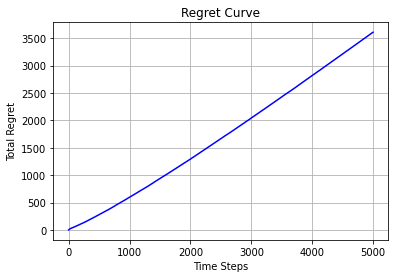

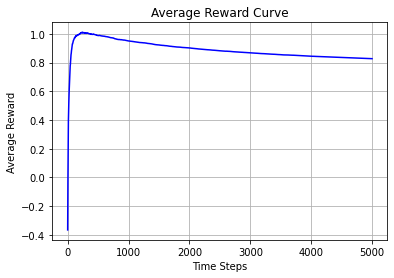

In [115]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "tau"               : 0.3, # The tau parameter
          "alpha"             : 0.1, # The learning rate
          "initialization"    : ZeroInitialization, # Initialization strategy
          "action_selection"  : custom_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "drunk"             : 0.1, # The "drunk" parameter [0,1]
          "drinking_rate"     : 0.5 # The "drinking rate" parameter
         }

#Run the experiment and plot:
estimates_drunk, total_reward_drunk, mean_rewards_drunk, regret_drunk = procedure(inputs,horizon)
plot_bandits(horizon, estimates_drunk, total_reward_drunk, mean_rewards_drunk, regret_drunk, q_star)

#### Min Initialization

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-1.53412357 -1.43677923 -1.33495458 -1.90919517 -1.35177598 -2.12267
 -0.56489972  0.3375256   1.54968501 -1.37473273]

Euclidean distance from q_star vector: 2.253384016719313
Total Reward: 3904.9451766191023
Mean Reward: 0.7809890353238208


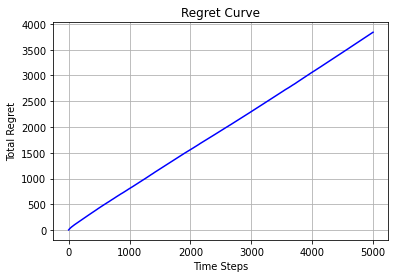

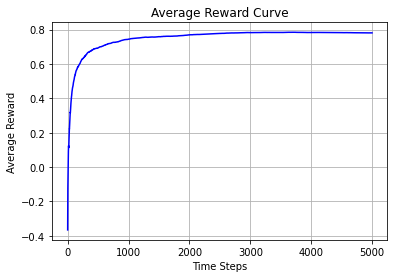

In [116]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "tau"               : 0.3, # The tau parameter
          "alpha"             : 0.1, # The learning rate
          "initialization"    : MinInitialization, # Initialization strategy
          "action_selection"  : custom_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "drunk"             : 0.1, # The "drunk" parameter [0,1]
          "drinking_rate"     : 0.5 # The "drinking rate" parameter
         }

#Run the experiment and plot:
min_estimates_drunk, min_total_reward_drunk, min_mean_rewards_drunk, min_regret_drunk = procedure(inputs,horizon)
plot_bandits(horizon, min_estimates_drunk, min_total_reward_drunk, min_mean_rewards_drunk, min_regret_drunk, q_star)

#### Max Initialization

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-1.00209731 -0.6263849  -0.59365124 -1.79927252 -0.02167578 -2.02577533
 -0.57928941  0.3376919   1.55008519 -1.37601981]

Euclidean distance from q_star vector: 0.4863997589451933
Total Reward: 4134.689996017005
Mean Reward: 0.8269379992034012


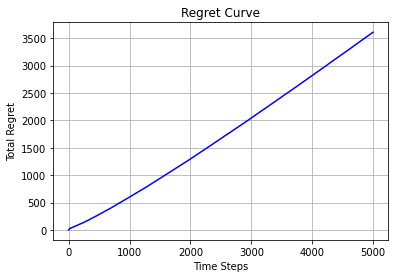

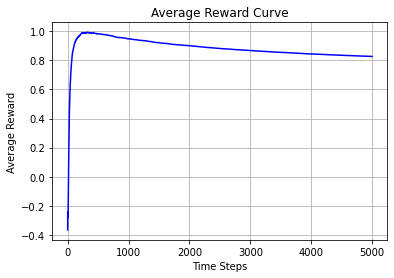

In [117]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "tau"               : 0.3, # The tau parameter
          "alpha"             : 0.1, # The learning rate
          "initialization"    : MaxInitialization, # Initialization strategy
          "action_selection"  : custom_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "drunk"             : 0.1, # The "drunk" parameter [0,1]
          "drinking_rate"     : 0.5 # The "drinking rate" parameter
         }

#Run the experiment and plot:
max_estimates_drunk, max_total_reward_drunk, max_mean_rewards_drunk, max_regret_drunk = procedure(inputs,horizon)
plot_bandits(horizon, max_estimates_drunk, max_total_reward_drunk, max_mean_rewards_drunk, max_regret_drunk, q_star)

#### Mean Initialization

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-1.0575485  -0.73671703 -0.65748063 -1.80408932 -0.0526402  -2.02845519
 -0.58993023  0.33695474  1.55000265 -1.37559689]

Euclidean distance from q_star vector: 0.6082789153391425
Total Reward: 4140.518211312507
Mean Reward: 0.8281036422625013


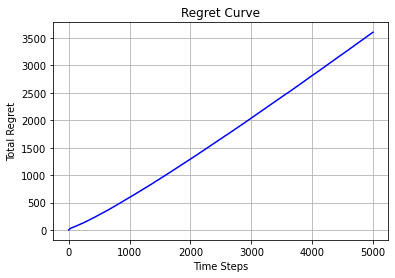

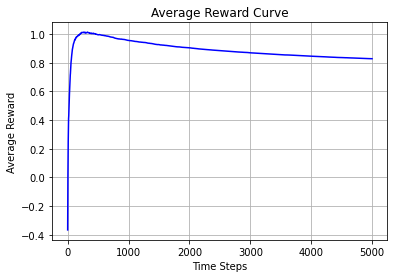

In [118]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "tau"               : 0.3, # The tau parameter
          "alpha"             : 0.1, # The learning rate
          "initialization"    : MeanInitialization, # Initialization strategy
          "action_selection"  : custom_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "drunk"             : 0.1, # The "drunk" parameter [0,1]
          "drinking_rate"     : 0.5 # The "drinking rate" parameter
         }

#Run the experiment and plot:
avg_estimates_drunk, avg_total_reward_drunk, avg_mean_rewards_drunk, avg_regret_drunk = procedure(inputs,horizon)
plot_bandits(horizon, avg_estimates_drunk, avg_total_reward_drunk, avg_mean_rewards_drunk, avg_regret_drunk, q_star)

#### Random Initialization

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-1.091988   -0.74917032 -0.73657478 -1.82656811 -0.3174587  -2.09252691
 -0.5833766   0.33662328  1.54995309 -1.37120926]

Euclidean distance from q_star vector: 0.8229939025230998
Total Reward: 4158.542612168706
Mean Reward: 0.8317085224337412


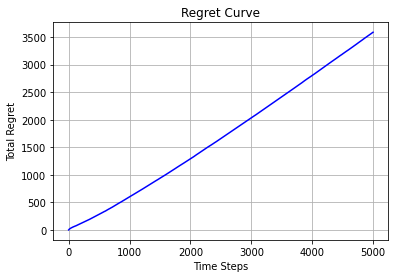

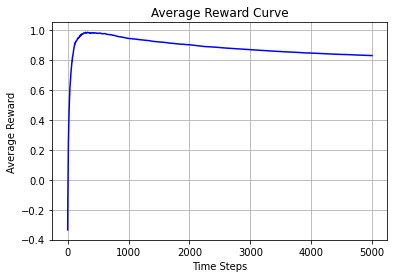

In [119]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "tau"               : 0.3, # The tau parameter
          "alpha"             : 0.1, # The learning rate
          "initialization"    : RandomInitialization, # Initialization strategy
          "action_selection"  : custom_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "drunk"             : 0.1, # The "drunk" parameter [0,1]
          "drinking_rate"     : 0.5 # The "drinking rate" parameter
         }

#Run the experiment and plot:
rnd_estimates_drunk, rnd_total_reward_drunk, rnd_mean_rewards_drunk, rnd_regret_drunk = procedure(inputs,horizon)
plot_bandits(horizon, rnd_estimates_drunk, rnd_total_reward_drunk, rnd_mean_rewards_drunk, rnd_regret_drunk, q_star)

#### Compare Initializations

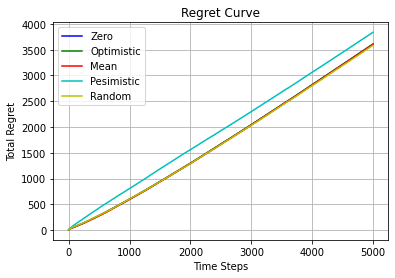

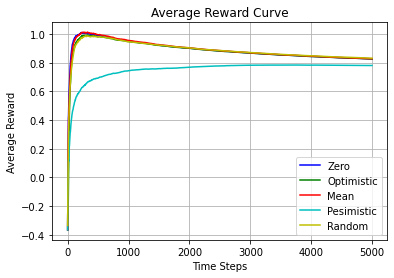

In [120]:
# Compare all
comp_plot(regret_drunk, min_regret_drunk, avg_regret_drunk, max_regret_drunk, rnd_regret_drunk, \
          mean_rewards_drunk, min_mean_rewards_drunk, avg_mean_rewards_drunk, max_mean_rewards_drunk, \
          rnd_mean_rewards_drunk)